#Setup

In [12]:
import math
import random

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter, UninitializedParameter
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn import init
from tqdm.notebook import trange, tqdm
import torchvision.transforms.functional as TF
from typing import Optional, List, Tuple, Union
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
import itertools
import numpy as np

In [13]:
dataset = 'FashionMNIST'
datadir = 'datasets'
arch = 'hhnmlpb'
batchsize = 64
epochs = 50
nlayers = 1
width = 32
lr = 0.001
dimensions = 5
hin = 2
nchannels = 1
nclasses = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load dataset

In [14]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(root="data", train=True, download=True, 
                                      transform=transforms.Compose([transforms.Resize((32, 32)),
                                                                    transforms.ToTensor()]),)

# Download test data from open datasets
test_data = datasets.FashionMNIST(root="data", train=False, download=True,
                                  transform=transforms.Compose([transforms.Resize((32, 32)),
                                                                    transforms.ToTensor()]),)

In [15]:
# Create data loaders
train_loader = DataLoader(training_data, batch_size=batchsize, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True, num_workers=8, pin_memory=True)

for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 32, 32])
Shape of y:  torch.Size([64]) torch.int64


#Prepare SCN

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class HHN_MLPB(nn.Module):
    def __init__(self, hin, dimensions, n_layers, n_units, n_channels, n_classes=10):
        super(HHN_MLPB, self).__init__()
        self.hyper_stack = nn.Sequential(
            nn.Linear(hin, 64),
            nn.ReLU(),
            nn.Linear(64, dimensions),
            nn.Softmax(dim=0)
        )

        self.dimensions = dimensions
        self.n_layers = n_layers
        self.n_units = n_units
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.bns = []

        self.weight_list_fc1, self.bias_list_fc1 = \
            self.create_param_combination_linear(in_features=32 * 32 * n_channels, out_features=n_units)
        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        for _ in range(n_layers - 1):
            w, b = self.create_param_combination_linear(in_features=n_units, out_features=n_units)
            self.weights += w
            self.biases += b
            self.bns.append(nn.BatchNorm1d(self.n_units).to(self.device))
        self.weight_list_fc2, self.bias_list_fc2 = self.create_param_combination_linear(in_features=n_units,
                                                                                        out_features=n_classes)

    def create_param_combination_linear(self, in_features, out_features):
        weight_list = nn.ParameterList()
        bias_list = nn.ParameterList()
        for _ in range(self.dimensions):
            weight = Parameter(torch.empty((out_features, in_features)))
            nn.init.kaiming_uniform_(weight, a=math.sqrt(5))
            weight_list.append(weight)

            bias = Parameter(torch.empty(out_features))
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(bias, -bound, bound)
            bias_list.append(bias)
        return weight_list, bias_list

    def calculate_weighted_sum(self, param_list: List, factors: Tensor):
        weighted_list = [a * b for a, b in zip(param_list, factors)]
        return torch.sum(torch.stack(weighted_list), dim=0)

    def forward(self, x, hyper_x):
        hyper_output = self.hyper_stack(hyper_x)

        weight_fc1 = self.calculate_weighted_sum(self.weight_list_fc1, hyper_output)
        weight_fc2 = self.calculate_weighted_sum(self.weight_list_fc2, hyper_output)

        bias_fc1 = self.calculate_weighted_sum(self.bias_list_fc1, hyper_output)
        bias_fc2 = self.calculate_weighted_sum(self.bias_list_fc2, hyper_output)

        logits = torch.flatten(x, start_dim=1)
        logits = F.linear(logits, weight=weight_fc1, bias=bias_fc1)
        logits = torch.relu(logits)

        it_w = iter(self.weights)
        it_b = iter(self.biases)
        for (w, b, bn) in zip(zip(*[it_w] * self.dimensions), zip(*[it_b] * self.dimensions), self.bns):
            w = nn.ParameterList(w)
            b = nn.ParameterList(b)
            w = self.calculate_weighted_sum(w.to(self.device), hyper_output)
            b = self.calculate_weighted_sum(b.to(self.device), hyper_output)
            logits = F.linear(logits, weight=w, bias=b)
            logits = bn(logits)
            logits = torch.relu(logits)
        logits = F.linear(logits, weight=weight_fc2, bias=bias_fc2)
        return logits

model = HHN_MLPB(2, dimensions, nlayers, width, 1, n_classes=10).to(device)
print(model)
print(count_model_parameters(model))

HHN_MLPB(
  (hyper_stack): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
    (3): Softmax(dim=0)
  )
  (weight_list_fc1): ParameterList(
      (0): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 32x1024 (GPU 0)]
  )
  (bias_list_fc1): ParameterList(
      (0): Parameter containing: [torch.float32 of size 32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 32 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 32 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 32 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 32 (GPU 0)]
  )
  (weights): Par

In [17]:
def transform_angle(angle):
    cos = math.cos(angle / 180 * math.pi)
    sin = math.sin(angle / 180 * math.pi)
    return Tensor([cos, sin])

#Train SCN

In [18]:
######## train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0)

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def train(dataloader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(tqdm(dataloader, desc='Training')):
        angle = random.uniform(0, 360)
        X, y = X.to(device), y.to(device)
        X = TF.rotate(X, angle)
        Hyper_X = transform_angle(angle).to(device)

        pred = model(X, Hyper_X)
        loss = loss_fn(pred, y)

        beta1 = model.hyper_stack(Hyper_X)
        angle2 = random.uniform(0, 360)
        beta2 = model.hyper_stack(transform_angle(angle2).to(device))
        loss += pow(cos(beta1, beta2),2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

def validate(dataloader, model, loss_fn):
    angle = random.uniform(0, 360)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = TF.rotate(X, angle)
            Hyper_X = transform_angle(angle).to(device)

            pred = model(X, Hyper_X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test with angle={angle}: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss

for t in range(epochs):
    print(f"=================\n Epoch: {t + 1} \n=================")
    train(train_loader, model, loss_fn, optimizer)
    test_acc, test_loss = validate(test_loader, model, loss_fn)
print("Done!")

 Epoch: 1 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=100.88803372068391: Accuracy: 70.9%, Avg loss: 0.790989
 Epoch: 2 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=304.0750316052254: Accuracy: 71.8%, Avg loss: 0.744199
 Epoch: 3 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=329.23051392464805: Accuracy: 76.0%, Avg loss: 0.667521
 Epoch: 4 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=299.19553646465334: Accuracy: 73.7%, Avg loss: 0.698737
 Epoch: 5 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=108.26854073726118: Accuracy: 75.7%, Avg loss: 0.665466
 Epoch: 6 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=219.99461207288488: Accuracy: 77.5%, Avg loss: 0.627151
 Epoch: 7 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=335.11539922822413: Accuracy: 78.3%, Avg loss: 0.609475
 Epoch: 8 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=110.93880269237022: Accuracy: 78.3%, Avg loss: 0.603717
 Epoch: 9 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=355.47557733133505: Accuracy: 78.1%, Avg loss: 0.589671
 Epoch: 10 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=66.4889479135702: Accuracy: 78.8%, Avg loss: 0.589482
 Epoch: 11 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=305.58604223083: Accuracy: 79.8%, Avg loss: 0.568259
 Epoch: 12 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=199.95285889396652: Accuracy: 78.5%, Avg loss: 0.586885
 Epoch: 13 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=82.12678819286587: Accuracy: 80.0%, Avg loss: 0.552861
 Epoch: 14 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=343.1409493824516: Accuracy: 79.6%, Avg loss: 0.565341
 Epoch: 15 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=247.60305003368774: Accuracy: 80.4%, Avg loss: 0.552835
 Epoch: 16 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=220.42931686843835: Accuracy: 78.7%, Avg loss: 0.582673
 Epoch: 17 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=257.4034904611242: Accuracy: 78.8%, Avg loss: 0.572628
 Epoch: 18 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=144.36684512835743: Accuracy: 78.7%, Avg loss: 0.579873
 Epoch: 19 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=356.38382732657925: Accuracy: 79.5%, Avg loss: 0.563140
 Epoch: 20 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=293.306192153146: Accuracy: 79.2%, Avg loss: 0.576428
 Epoch: 21 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=106.06793215773031: Accuracy: 81.2%, Avg loss: 0.525464
 Epoch: 22 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=85.1634236298464: Accuracy: 80.0%, Avg loss: 0.543914
 Epoch: 23 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=221.89852046448107: Accuracy: 80.5%, Avg loss: 0.542225
 Epoch: 24 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=110.05050301406314: Accuracy: 80.8%, Avg loss: 0.521400
 Epoch: 25 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=238.94438683021804: Accuracy: 81.2%, Avg loss: 0.531840
 Epoch: 26 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=179.41878747067597: Accuracy: 82.0%, Avg loss: 0.501362
 Epoch: 27 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=294.03163219142425: Accuracy: 80.9%, Avg loss: 0.524889
 Epoch: 28 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=99.01552326632118: Accuracy: 81.4%, Avg loss: 0.514407
 Epoch: 29 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=180.10744719329332: Accuracy: 82.5%, Avg loss: 0.489242
 Epoch: 30 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=263.53282489050144: Accuracy: 80.3%, Avg loss: 0.539837
 Epoch: 31 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=22.224845863111106: Accuracy: 82.3%, Avg loss: 0.500403
 Epoch: 32 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=313.28783925735047: Accuracy: 82.0%, Avg loss: 0.507438
 Epoch: 33 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=266.76771160271505: Accuracy: 80.4%, Avg loss: 0.529652
 Epoch: 34 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=7.050513913296421: Accuracy: 81.6%, Avg loss: 0.515900
 Epoch: 35 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=182.13753811976983: Accuracy: 82.0%, Avg loss: 0.504039
 Epoch: 36 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=28.8424945933222: Accuracy: 82.4%, Avg loss: 0.498611
 Epoch: 37 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=280.3082386536765: Accuracy: 81.8%, Avg loss: 0.508457
 Epoch: 38 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=53.17587110256836: Accuracy: 81.8%, Avg loss: 0.507801
 Epoch: 39 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=8.758265196291388: Accuracy: 82.1%, Avg loss: 0.502274
 Epoch: 40 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=314.20029015592985: Accuracy: 82.3%, Avg loss: 0.494366
 Epoch: 41 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=151.8567899519658: Accuracy: 82.4%, Avg loss: 0.490214
 Epoch: 42 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=18.1984169952775: Accuracy: 82.3%, Avg loss: 0.494380
 Epoch: 43 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=255.82787781373042: Accuracy: 82.3%, Avg loss: 0.495613
 Epoch: 44 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=68.47150207198791: Accuracy: 82.1%, Avg loss: 0.491856
 Epoch: 45 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=298.5567531571553: Accuracy: 82.5%, Avg loss: 0.493799
 Epoch: 46 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=21.58697643040094: Accuracy: 82.6%, Avg loss: 0.485383
 Epoch: 47 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=347.4999827981487: Accuracy: 81.9%, Avg loss: 0.506910
 Epoch: 48 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=73.95751911006462: Accuracy: 82.7%, Avg loss: 0.487392
 Epoch: 49 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=201.2777118284583: Accuracy: 81.5%, Avg loss: 0.515083
 Epoch: 50 


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Test with angle=270.1049173681241: Accuracy: 81.5%, Avg loss: 0.515173
Done!


#Test SCN

In [19]:
######## test model
def test(dataloader, model, loss_fn, angle):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = TF.rotate(X, angle)
            Hyper_X = transform_angle(angle).to(device)

            pred = model(X, Hyper_X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test with angle={angle}: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct

acc = []
for angle in tqdm(range(360), desc='Testing'):
    acc.append(test(test_loader, model, loss_fn, angle))

Testing:   0%|          | 0/360 [00:00<?, ?it/s]

Test with angle=0: Accuracy: 82.4%, Avg loss: 0.497248
Test with angle=1: Accuracy: 82.4%, Avg loss: 0.499184
Test with angle=2: Accuracy: 82.0%, Avg loss: 0.503835
Test with angle=3: Accuracy: 82.0%, Avg loss: 0.505546
Test with angle=4: Accuracy: 82.0%, Avg loss: 0.503064
Test with angle=5: Accuracy: 82.1%, Avg loss: 0.499731
Test with angle=6: Accuracy: 82.2%, Avg loss: 0.498354
Test with angle=7: Accuracy: 82.2%, Avg loss: 0.496743
Test with angle=8: Accuracy: 82.2%, Avg loss: 0.497087
Test with angle=9: Accuracy: 82.3%, Avg loss: 0.497979
Test with angle=10: Accuracy: 82.2%, Avg loss: 0.497998
Test with angle=11: Accuracy: 82.2%, Avg loss: 0.496208
Test with angle=12: Accuracy: 82.3%, Avg loss: 0.494535
Test with angle=13: Accuracy: 82.3%, Avg loss: 0.492265
Test with angle=14: Accuracy: 82.4%, Avg loss: 0.491200
Test with angle=15: Accuracy: 82.2%, Avg loss: 0.496149
Test with angle=16: Accuracy: 82.5%, Avg loss: 0.493241
Test with angle=17: Accuracy: 82.4%, Avg loss: 0.489910
Te

In [20]:
######## compute beta space
beta_space = []
for angle in range(360):
    Hyper_X = transform_angle(angle).to(device)
    beta_space.append(model.hyper_stack(Hyper_X).cpu().detach().numpy())

beta_space = np.stack(beta_space)
print(beta_space.shape)

(360, 5)


In [22]:
import os
import pickle
save_dir = ""

hhn_dict = {'acc': acc, 'beta_space': np.array(beta_space)}
destination_name = f'output/{save_dir}'
os.makedirs(destination_name, exist_ok=True)
np.save(f'{destination_name}/acc.npy', pickle.dumps(hhn_dict))

torch.save(model.state_dict(), f'{destination_name}/model.pt')

#Plot

In [23]:
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import StrMethodFormatter

<Figure size 640x480 with 0 Axes>

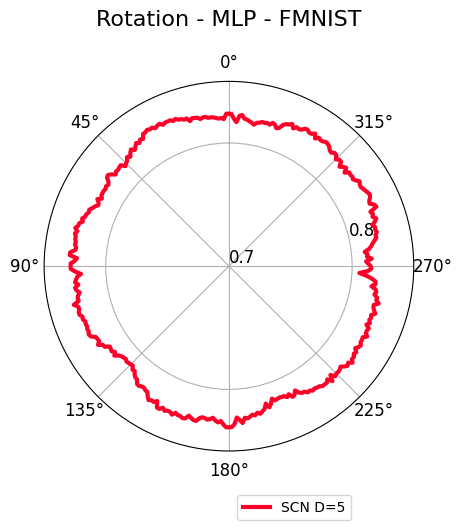

In [25]:
# Plot acc
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 5))

theta = np.arange(0, 360, 1) / 180 * math.pi

fig = plt.figure()
fig.tight_layout()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

file_name = f'output/acc.npy'
acc_hhn = pickle.loads(np.load(file_name))
ax.plot(theta, acc_hhn['acc'], label=f'SCN D={dimensions}', color=colors[0], lw=3)

ax.set_theta_zero_location("N")
ax.set_rticks([0.7, 0.8, 0.90])  # Less radial ticks
ax.set_rmin(0.7)
ax.set_rmax(0.85)
ax.set_rlabel_position(-77.5)  # Move radial labels away from plotted line
ax.grid(True)
plt.title('Rotation - MLP - FMNIST', fontsize=16, pad=20)
plt.legend(bbox_to_anchor=(0.85, -0.1), ncol=2, prop={'size': 10})
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
# plt.savefig(f"viz_acc_{arch}_{dataset}_{nlayers}_{width}.png", bbox_inches='tight', dpi=100)
plt.show()

<Figure size 640x480 with 0 Axes>

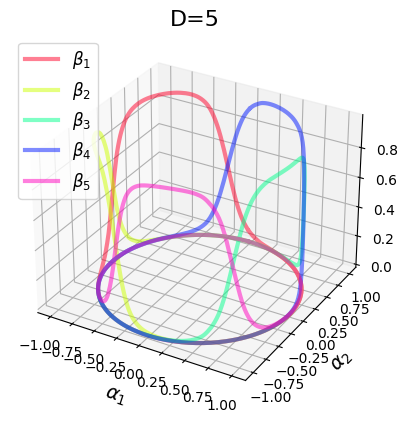

In [27]:
# Beta space
plt.rcParams.update({'font.size': 10, 'legend.fontsize': 14})

fig = plt.figure()
fig.tight_layout()
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
            
file_name = f'output/acc.npy'
acc_hhn = pickle.loads(np.load(file_name))
plt.rc('font', **{'size': 4})
cols = cm.gist_rainbow(np.linspace(0, 1, dimensions))
xline = np.sin(theta)
yline = np.cos(theta)
for i in range(len(acc_hhn['beta_space'][0])):
    zline = acc_hhn['beta_space'][:, i]
    ax.plot(xline, yline, zline, alpha=0.5, color=cols[i], label=r'$\beta_{%d}$' % (i + 1), lw=3)
    ax.legend(loc='upper left', prop={'size': 12})
    ax.axes.xaxis.labelpad = 5
    ax.axes.yaxis.labelpad = 5
    ax.set_xlabel(r'$\alpha_1$', fontsize=14)
    ax.set_ylabel(r'$\alpha_2$', fontsize=14)
    ax.grid(True, linestyle=':')
    ax.set_title(f'D={dimensions}', fontsize=16)
# plt.savefig(f"viz_beta_{arch}_{dataset}_{nlayers}_{width}.png", bbox_inches='tight', dpi=100)
plt.show()